In [1]:
from importlib import reload

import universe
reload(universe)
from universe import *

# import mass_function
# reload(mass_function)
# from mass_function import *

# import profiles
# reload(profiles)
# from profiles import *

# import p3d
# reload(p3d)
# from p3d import *

import projection_kernel
reload(projection_kernel)
from projection_kernel import *

# import i_halo_model
# reload(i_halo_model)
# from i_halo_model import *

import p2d
reload(p2d)
from p2d import *

### Calculating $\frac{dn^G}{dz}$ and/or $\phi(z)$


In [9]:
def gaussian(z, z_ph):
    # assuming delta_z is negligible
    sig = 0.03*(1+z)
    result = np.exp(-np.square((z_ph - z) / sig) / 2) / (np.sqrt(2.0 * np.pi) * sig)
    return result

def z_dist(z):
    # TODO check the normalization of this function 
    z0 = 0.11
    alpha = 0.68
    # for normalization 
    ngal_per_arcmin2 = 27 # galaxies per squared arcmin
    ngal = ngal_per_arcmin2 / (np.pi/180./60.)**2
    f = ngal*(z**2. * np.exp(-(z/z0)**alpha))
    return f 

def z_dist_sliced(z, z_i, z_f):
    if z_i <= z <= z_f:
        return z_dist(z)
    else:
        return 0

def phi_Alonso(z, z_i, z_f):
    integral = integrate.quad(lambda z_ph: gaussian(z, z_ph), z_i, z_f)[0]
    result = z_dist(z)*integral
    return result

def dndz_Schaan(z, z_i, z_f):
    result = integrate.quad(lambda z_ph: z_dist(z)*gaussian(z, z_ph), z_i, z_f)[0]
    return result



Plotting of assumed redshift distribution of LSST Gold sample alone. I also illustrate an example of one of the redshift slices we will be calculating the redshift distribution for just for visualization sake.

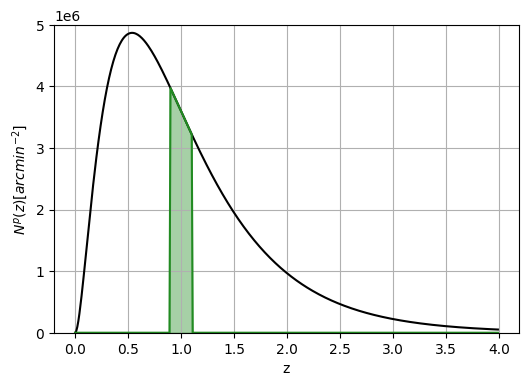

In [10]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

z_range = np.arange(0, 4, 0.01)
z_distribution = list(map(z_dist, z_range))
slice = [z_dist_sliced(z, 0.9, 1.1) for z in z_range]
plt.figure(figsize=(6, 4))  
plt.plot(z_range, z_distribution, color='black')
plt.fill_between(z_range, slice, step="pre", alpha=0.4, color='forestgreen')
plt.plot(z_range, slice, color='forestgreen')
plt.ylim(0, 5*10**6)
plt.xlabel('z')
plt.ylabel(r'$N^p (z) [arcmin^{-2}]$')
plt.grid(True) 
plt.show()

The next step is to compute the $\frac{dn^G}{dz}$ and $\phi(z)$. For simplicity, let's start with just the highlighted redshift bin. Below, we compute the true redshift distribution both for Schaan et al. 2021 and Alonso et al. 2017.

/Users/anacarolinaoliveira/miniconda3/envs/LIMenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


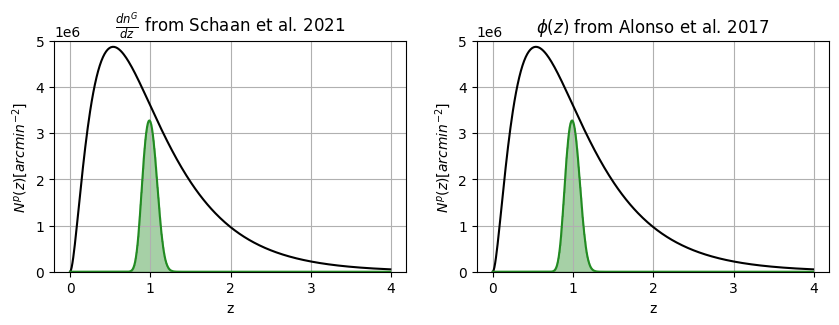

In [13]:
z_range = np.arange(0, 4, 0.01)
z_distribution = list(map(z_dist, z_range))
dndz = [dndz_Schaan(z, 0.9, 1.1) for z in z_range]
phi = [phi_Alonso(z, 0.9, 1.1) for z in z_range]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(z_range, z_distribution, color='black')
ax1.fill_between(z_range, dndz, step="pre", alpha=0.4, color='forestgreen')
ax1.plot(z_range, dndz, color='forestgreen')
ax1.set_ylim(0, 5*10**6)
ax1.set_xlabel('z')
ax1.set_ylabel(r'$N^p (z) [arcmin^{-2}]$')
ax1.set_title(r'$\frac{dn^G}{dz}$ from Schaan et al. 2021')
ax1.grid(True) 
ax2.plot(z_range, z_distribution, color='black')
ax2.fill_between(z_range, phi, step="pre", alpha=0.4, color='forestgreen')
ax2.plot(z_range, phi, color='forestgreen')
ax2.set_ylim(0, 5*10**6)
ax2.set_xlabel('z')
ax2.set_ylabel(r'$N^p (z) [arcmin^{-2}]$')
ax2.set_title(r'$\phi(z)$ from Alonso et al. 2017')
ax2.grid(True) 
fig.show()

Now let's follow this procedure and calculate the true redshift distribution for a set of 15 redshift bins. I'm going to initially just do a very simple binning, splitting the total redshift span into z-bins of equal size.

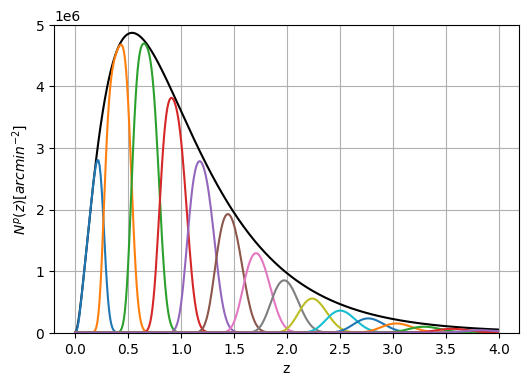

In [14]:
def binning(n_bins, z_start=0, z_end=4):
    z_range = z_end - z_start
    width = z_range / n_bins
    edges = list()
    z = z_start
    while z < z_end:
        edges.append([z, z+width])
        z+=width
    if len(edges) > n_bins:
        edges.remove(edges[-1])
    return edges

bins = binning(15)

plt.figure(figsize=(6, 4))  
plt.plot(z_range, z_distribution, color='black')
for i in range(len(bins)):
    plt.plot(z_range, [dndz_Schaan(z, bins[i][0], bins[i][1]) for z in z_range])
plt.ylim(0, 5*10**6)
plt.xlabel('z')
plt.ylabel(r'$N^p (z) [arcmin^{-2}]$')
plt.grid(True) 
plt.savefig('./output/plots/dndz_Schaan_15bins.pdf')

Comparing with Alonso, we can see that the result is quite similar.

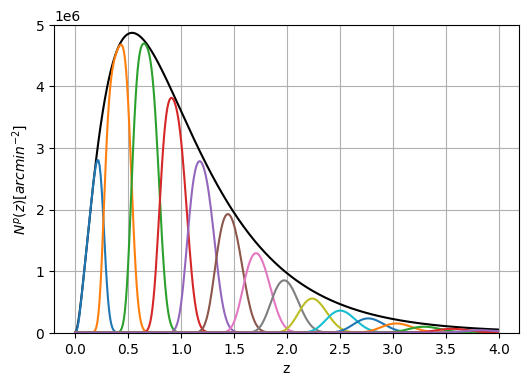

In [15]:
plt.figure(figsize=(6, 4))  
plt.plot(z_range, z_distribution, color='black')
for i in range(len(bins)):
    plt.plot(z_range, [phi_Alonso(z, bins[i][0], bins[i][1]) for z in z_range])
plt.ylim(0, 5*10**6)
plt.xlabel('z')
plt.ylabel(r'$N^p (z) [arcmin^{-2}]$')
plt.grid(True) 
plt.show()

We see that the calculation produced the expected behavior. From this point on, we work with the formalism defined in Schaan et al. 2021. This function has then been implemented to the code under a new weight function. Let's run some sanity checks on the results we can get with it. 

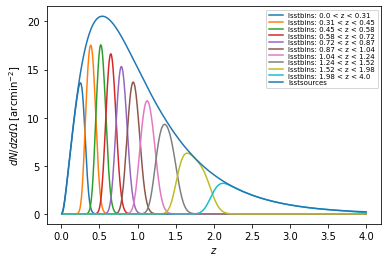

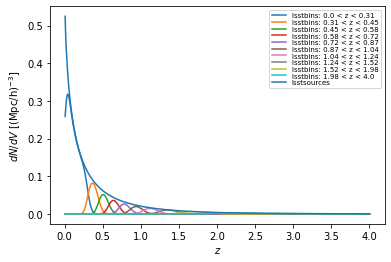

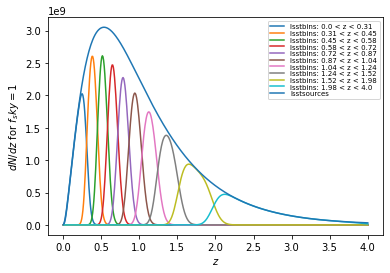

In [1]:
#debugging normalization
from importlib import reload

import universe
reload(universe)
from universe import *

import projection_kernel
reload(projection_kernel)
from projection_kernel import *

import p2d
reload(p2d)
from p2d import *

# initialize the universe 
u = UnivPlanck15()

# following weight function's dn/dz is the 
# curve for which we would like to conduct 
# the binning (here, defined as z_dist())
w = WeightTracerLSSTSourcesDESCSRDV1(u)
binedges = w.splitBins(10)

# array with weight functions for each z bin
wArr = [WeightTracerLSSTBins(u, zphMin=binedges[edge], zphMax=binedges[edge+1]) for edge in range(len(binedges)-1)]

wArr.append(w) #adding the weight function for the total black curve
w.plotDndz(wArr=wArr)


Another check we can try is seeing if $\phi(z)$ recovers the shape of the assumed redshift distribution as we widen the redshift bin to basically no cutoffs.

lsstbins: 27.0gal/arcmin^2


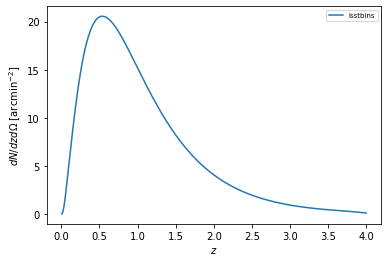

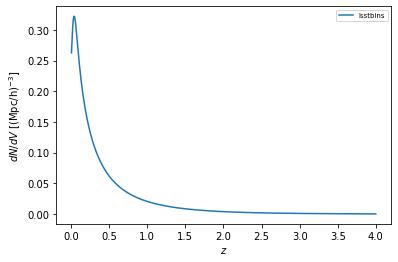

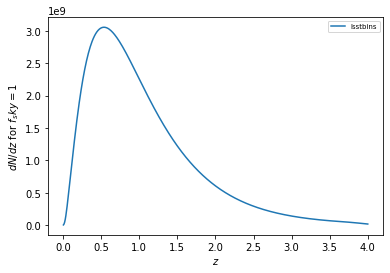

In [3]:
w_bin_nocut = WeightTracerLSSTBins(u, zphMin=0.005, zphMax=4.)
w_bin_nocut.plotDndz()

Finally, one last useful check is to change the size of $\sigma(z)$, and see how the behavior of $\phi(z)$ changes. Let's check for an individual bin.


0.0881442600000001
lsstbins: 20.34gal/arcmin^2


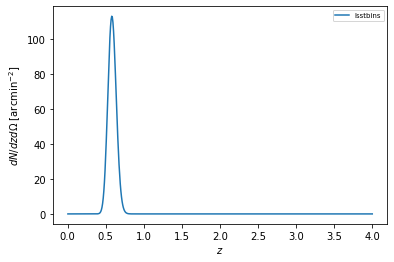

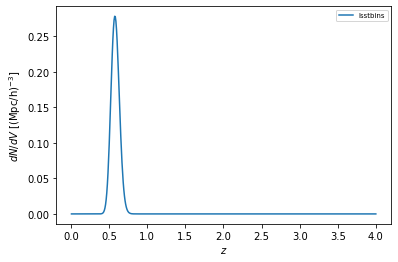

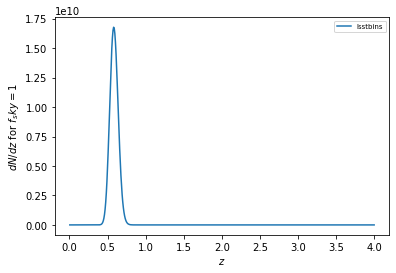

In [4]:
# original sigma
w_bin_sig1 = WeightTracerLSSTBins(u, zphMin=0.54016117, zphMax=0.62830543)
w_bin_sig1.plotDndz()

0.0881320500434776
lsstbins: 19.54gal/arcmin^2


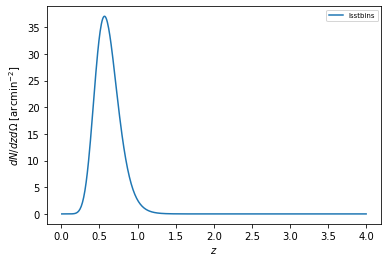

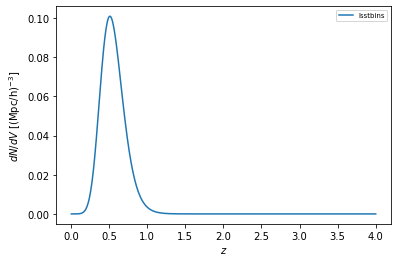

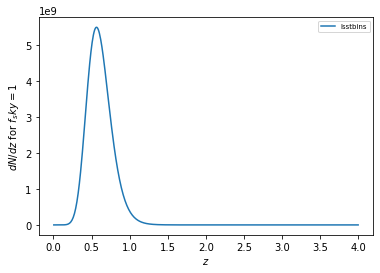

In [4]:
# larger sigma; expect the distribution to widen
w_bin_sig2 = WeightTracerLSSTBins(u, zphMin=0.54016117, zphMax=0.62830543, sigma=lambda z: 0.1*(1+z))
w_bin_sig2.plotDndz()

0.08814426000000006
lsstbins: 20.41gal/arcmin^2


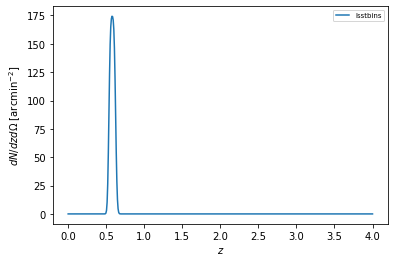

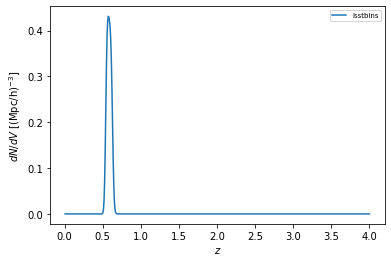

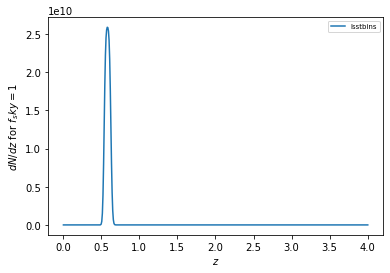

In [5]:
# smaller sigma; expect the distribution to narrow 
w_bin_sig3 = WeightTracerLSSTBins(u, zphMin=0.54016117, zphMax=0.62830543, sigma=lambda z: 0.01*(1+z))
w_bin_sig3.plotDndz()

In [8]:
# finally, sigma->0; I think we expect the curve to take the shape of the step function of the assumed z dist in the chosen bin
# w_bin_sig4 = WeightTracerLSSTBins(u, zphMin=0.54016117, zphMax=0.62830543, sigma=lambda z: 0.03*(1+z))
# w_bin_sig4.plotDndz()

### Calculating $C_{\ell}$

##### Auto-spectra

Starting the 2D power spectrum calculation at just one bin.

lsstbins: 0.04gal/arcmin^2
precomputing p2d lsstbinsbin1
precomputing bare vs counter terms


<Figure size 432x288 with 0 Axes>

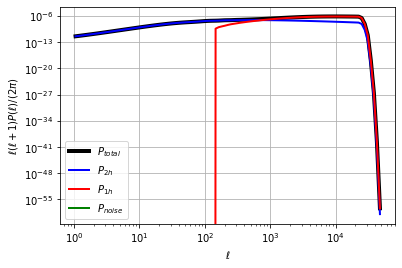

precomputing p2d lsstbinsbin1
precomputing bare vs counter terms


<Figure size 432x288 with 0 Axes>

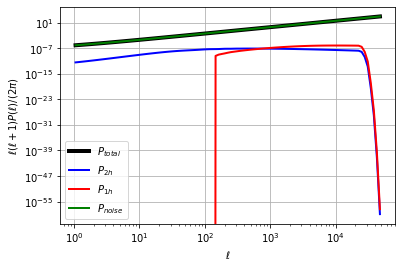

In [3]:
u = UnivPlanck15()

w_bin = WeightTracerLSSTBins(u, zphMin=0.54016117, zphMax=0.62830543)

# 2D (noiseless) auto spectrum 
p2d_wbin1 = P2dAuto(u, u, w_bin, nProc=3, name='bin1', save=True)
p2d_wbin1.plotP()

# 2D auto spectrum with noise
p2d_wbin1_noise = P2dAuto(u, u, w_bin, pNoise=lambda l:1./w_bin.ngal, nProc=3, name='bin1', save=True)
p2d_wbin1_noise.plotP()

In [ ]:
# using plotP() to plot the power spectrum for multiple bins 

##### Cross-spectra

cmass: 0.02gal/arcmin^2


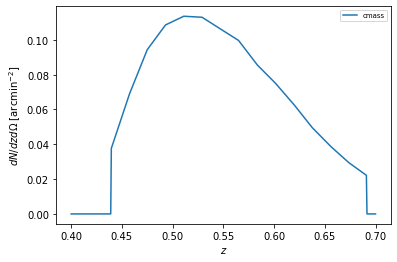

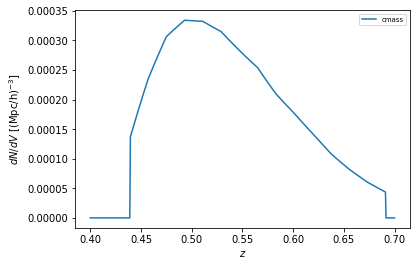

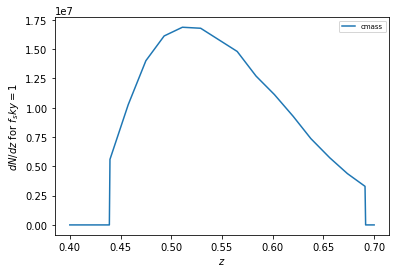

In [3]:
w_cmass= WeightTracerCMASS(u)
w_cmass.plotDndz()

precomputing p2d lsstbinscmass
precomputing bare vs counter terms


<Figure size 432x288 with 0 Axes>

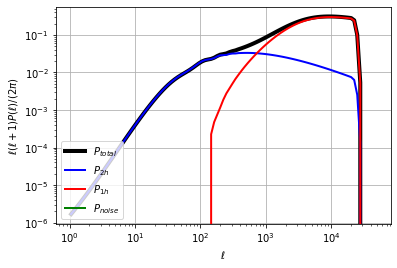

In [4]:
p2d_bincmass = P2dCross(u, u, w_bin, w_cmass, nProc=3, save=True)
p2d_bincmass.plotP()